In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Tue Jan 16 17:27:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.vae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.16-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 40197149.99it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████| 28881/28881 [00:00<00:00, 2299462.68it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 23702661.27it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 8322642.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


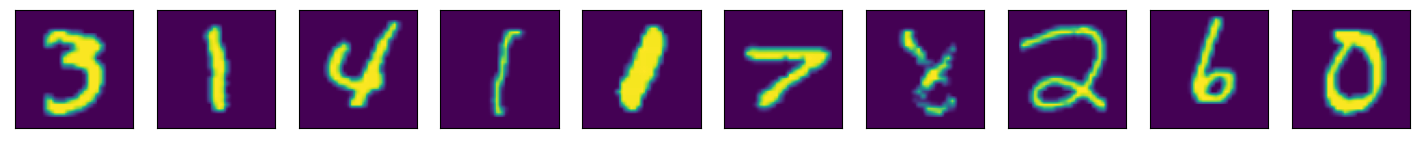

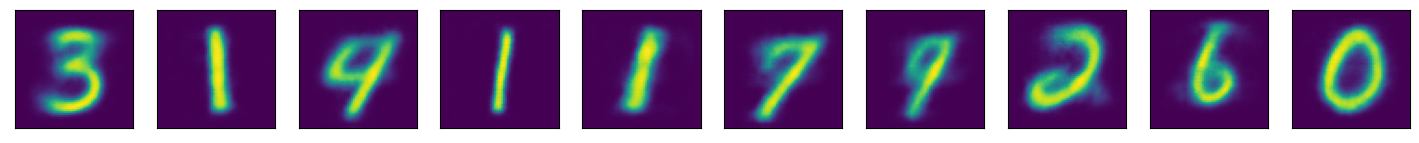

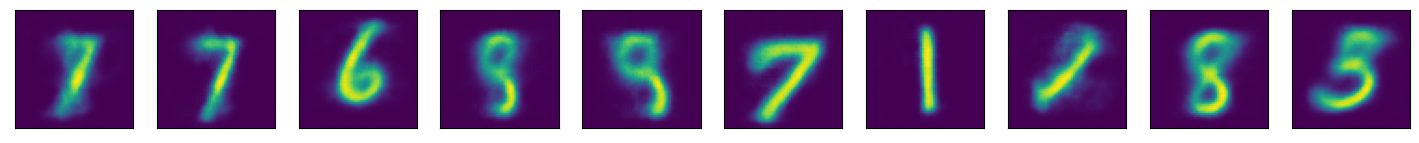

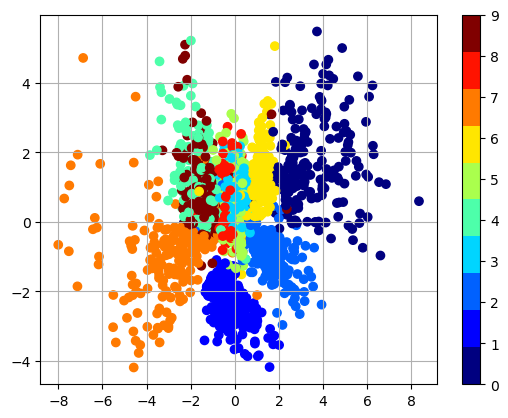

1001
kl_loss 9.36417293548584
recon_loss 0.12659576907753944
1002
kl_loss 9.625242996215821
recon_loss 0.12308846712112427
1003
kl_loss 9.489179801940917
recon_loss 0.11691589131951333
1004
kl_loss 9.575523090362548
recon_loss 0.1272561676800251
1005
kl_loss 9.688015937805176
recon_loss 0.12358971014618873
1006
kl_loss 9.512546920776368
recon_loss 0.12104558944702148
1007
kl_loss 9.39175786972046
recon_loss 0.12447443976998329
1008
kl_loss 9.337581253051757
recon_loss 0.12097788602113724
1009
kl_loss 9.445684432983398
recon_loss 0.1224679060280323
1010
kl_loss 9.417102813720703
recon_loss 0.1288642093539238
1011
kl_loss 9.43628454208374
recon_loss 0.11678831577301026
1012
kl_loss 9.730462169647216
recon_loss 0.12375717684626579
1013
kl_loss 9.549137115478516
recon_loss 0.12760461419820784
1014
kl_loss 9.754907417297364
recon_loss 0.12541231364011765
1015
kl_loss 9.594843864440918
recon_loss 0.12135246694087982
1016
kl_loss 9.640960121154786
recon_loss 0.12852529659867287
1017
kl_loss 9

1134
kl_loss 9.287371158599854
recon_loss 0.12002414092421532
1135
kl_loss 9.253722286224365
recon_loss 0.12432676330208778
1136
kl_loss 9.469666671752929
recon_loss 0.12070032507181168
1137
kl_loss 9.22882080078125
recon_loss 0.12062321528792382
1138
kl_loss 9.333006763458252
recon_loss 0.12385072708129882
1139
kl_loss 9.578546619415283
recon_loss 0.12102538198232651
1140
kl_loss 9.243656444549561
recon_loss 0.11976260170340539
1141
kl_loss 9.625921249389648
recon_loss 0.12111600488424301
1142
kl_loss 9.382034492492675
recon_loss 0.12112649008631707
1143
kl_loss 9.354737377166748
recon_loss 0.1229336403310299
1144
kl_loss 9.096519374847412
recon_loss 0.11778817102313041
1145
kl_loss 9.33816900253296
recon_loss 0.12053843960165977
1146
kl_loss 9.258097934722901
recon_loss 0.13065100759267806
1147
kl_loss 9.098233604431153
recon_loss 0.12151783481240272
1148
kl_loss 9.174962043762207
recon_loss 0.11941957026720047
1149
kl_loss 9.22925443649292
recon_loss 0.1270551860332489
1150
kl_loss 

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=1024)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=1024)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        